In [1]:
# import packages for visualization
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from map_plan import *

In [4]:
sample_map = create_sample_map()
obstacle_map = sample_map[:,:,0]
goal_map = sample_map[:,:,1]
current_pos_map = sample_map[:,:,2]

/Users/kyunghyuncho/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


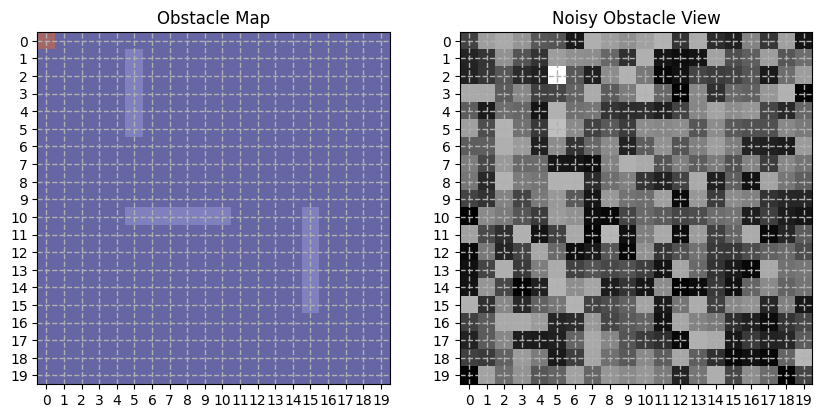

In [5]:
# on the left panel, visualize the obstacle map and put the bot on the current position.
# on the right panel, visualize the noisy obstacle view from the bot's perspective.
# use the integer ticks on both x and y axes and put a soft grid.

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(obstacle_map, cmap='gray', alpha=0.2)
ax[0].imshow(current_pos_map, cmap='jet', alpha=0.5)
ax[0].grid(True, which='both', linestyle='--', linewidth=1)
ax[0].set_xticks(np.arange(0., obstacle_map.shape[1], 1))
ax[0].set_yticks(np.arange(0., obstacle_map.shape[0], 1))
ax[0].set_title('Obstacle Map')

noisy_view_bot = obstacle_view(obstacle_map, 
                               get_soft_position(*get_hard_position(current_pos_map, argmax=True), 
                                                 beta=0.1), 
                               noise=0.01)
ax[1].imshow(noisy_view_bot, cmap='gray')
ax[1].grid(True, which='both', linestyle='--', linewidth=1)
ax[1].set_xticks(np.arange(0., obstacle_map.shape[1], 1))
ax[1].set_yticks(np.arange(0., obstacle_map.shape[0], 1))
ax[1].set_title('Noisy Obstacle View')

plt.show()

In [8]:
# take a random walk from the current position,
# and make noisy observation of the obstacles.

# initialize the current position
current_pos = get_hard_position(current_pos_map, argmax=True)

# initialize the estimated obstacle map
obstacle_map_est = 0.01 * torch.randn_like(obstacle_map)
obstacle_map_est.requires_grad = True
optimizer = torch.optim.SGD([obstacle_map_est], lr=0.1)

n_steps = 1000
n_inner_steps = 10
random_walk_trajectory = []

def take_random_step(current_pos, obstacle_map):
    max_tol = 10
    for ti in range(max_tol):
        next_pos = (current_pos[0] + np.random.choice([-1, 0, 1]), 
                    current_pos[1] + np.random.choice([-1, 0, 1]))
        next_pos = (np.clip(next_pos[0], 0, obstacle_map.shape[0]-1), 
                    np.clip(next_pos[1], 0, obstacle_map.shape[1]-1))
        if obstacle_map[next_pos] == 0:
            return next_pos
    assert False, 'cannot find a valid next position'

# take random walk, make noisy observation and update the estimated obstacle map
for step in range(n_steps):
    # take a random walk
    current_pos = take_random_step(current_pos, obstacle_map)
    random_walk_trajectory.append(current_pos)
    # make noisy observation
    noisy_view_bot = obstacle_view(obstacle_map, 
                                   get_soft_position(*current_pos, beta=0.1), 
                                   noise=0.05)
    # update the estimated obstacle map
    loss = update_obstacle_map(obstacle_map_est,
                               get_soft_position(*current_pos, beta=0.1), 
                               noisy_view_bot, 
                               optimizer=optimizer,
                               n_steps=n_inner_steps)
    # print the loss
    if step % 100 == 0:
        print(f'step {step}, loss {loss.item():.4f}')

step 0, loss 9.4577
step 100, loss 9.7710
step 200, loss 9.6507
step 300, loss 9.2775
step 400, loss 9.4387


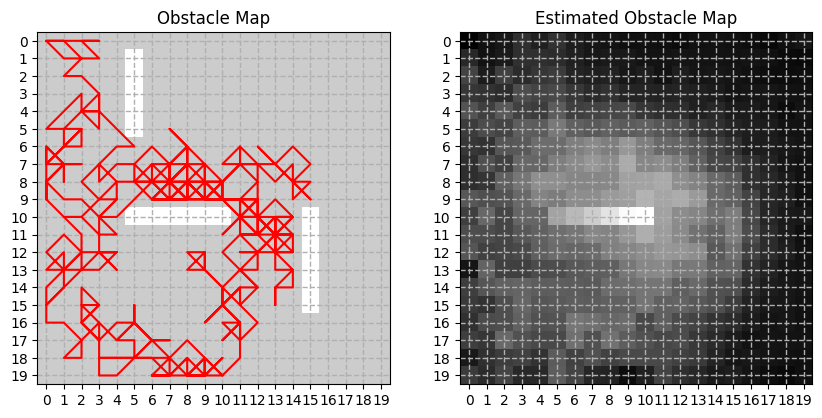

In [9]:
# on the left panel, plot the obstacle map and overlay the random walk trajectory.
# on the right panel, plot the estimated obstacle map.
# put a color bar on both panels and use the integer ticks on both x and y axes.

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(obstacle_map, cmap='gray', alpha=0.2)
ax[0].plot([pos[1] for pos in random_walk_trajectory], 
           [pos[0] for pos in random_walk_trajectory], 'r-')
ax[0].grid(True, which='both', linestyle='--', linewidth=1)
ax[0].set_xticks(np.arange(0., obstacle_map.shape[1], 1))
ax[0].set_yticks(np.arange(0., obstacle_map.shape[0], 1))
ax[0].set_title('Obstacle Map')

ax[1].imshow(torch.sigmoid(obstacle_map_est).detach().numpy(), cmap='gray')
ax[1].grid(True, which='both', linestyle='--', linewidth=1)
ax[1].set_xticks(np.arange(0., obstacle_map.shape[1], 1))
ax[1].set_yticks(np.arange(0., obstacle_map.shape[0], 1))
ax[1].set_title('Estimated Obstacle Map')

plt.show()